# **Demand Forecasting**

We have 1 year of online item sales data, and will be predicting for the next 3 months.

# Importing Libraries 

In [ ]:
!pipreqsnb /Users/user/Passion8/demand_forecast/store_demand.ipynb

In [3]:
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
import sqlalchemy
import plotly.graph_objs as go
from plotly.offline import iplot
import warnings
import plotly.express as px
from dotenv import load_dotenv
from statsmodels.graphics.tsaplots import plot_acf
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [5]:
#load from .env file
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

load_dotenv(f'{parent_dir}/.env')

postgres_password = os.getenv('POSTGRES_PASSWORD')
postgres_port_no = os.getenv('POSTGRES_PORT_NO')
host = os.getenv('POSTGRES_HOST')
database = os.getenv('POSTGRES_DB')
user = os.getenv('POSTGRES_USER')



In [6]:
# Create a database engine
engine = sqlalchemy.create_engine(f'postgresql://{user}:{postgres_password}@{host}:{postgres_port_no}/{database}')

In [7]:
def create_df():
    try:
        connection = engine.connect() # Connect to the database
        query = '''
        SELECT 
            date, product_id, SUM(quantity) AS sales
        FROM
            online_sales 
        GROUP BY
            date, product_id
        ORDER BY
            date, product_id;
        '''
        # Read data from the database into a DataFrame
        df = pd.read_sql(query, con=connection)
        return df
    except Exception as e:
        print("An error occurred:", e)
        connection.rollback()  # Rollback in case of error
    finally:
        connection.close()  # Close the connection

# Display the DataFrame
train_df = create_df()
train_df.head()

,date,product_id,sales
0,2019-01-01,B00C3GBCIS,1
1,2019-01-01,B00J5DYCCA,1
2,2019-01-01,B00KRCBA6E,4
3,2019-01-01,B00LZLQ624,1
4,2019-01-01,B00O24PUO6,1


The query is used to retrieve all sales to forecast demand despite of shipping and order status as in our perspective, even if the order was cancelled, it was still once requested and should be accounted into demand

In [8]:
# Change date column to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
# Create a date range for the year 2020, range of 90 days
dates = pd.date_range(start='2020-01-01', end='2020-03-30', freq='D')

# Get all unique product IDs and have every date for each product ID
product_ids = train_df['product_id'].unique()
dates = np.repeat(dates, len(product_ids))

# Create the new DataFrame
test_df = pd.DataFrame({'date': dates, 'product_id': np.tile(product_ids, len(dates)//len(product_ids))})

test_df['sales'] = np.nan

In [14]:
lag_size = (test_df['date'].max() - train_df['date'].max()).days
print('Max date from train set: %s' % train_df['date'].max().date())
print('Max date from test set: %s' % test_df['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2019-12-31
Max date from test set: 2020-03-30
Forecast lag size 90


### Basic EDA

To explore the time series data first we need to aggregate the sales by day

In [9]:
train = train_df.copy()

In [16]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['product_id', 'date'], as_index=False)['sales'].sum()

### Overall daily sales

In [17]:
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

### Daily sales by item

In [18]:
item_daily_sales_sc = []
for item in item_daily_sales['product_id'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['product_id'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Product %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

## Trend and Seasonality

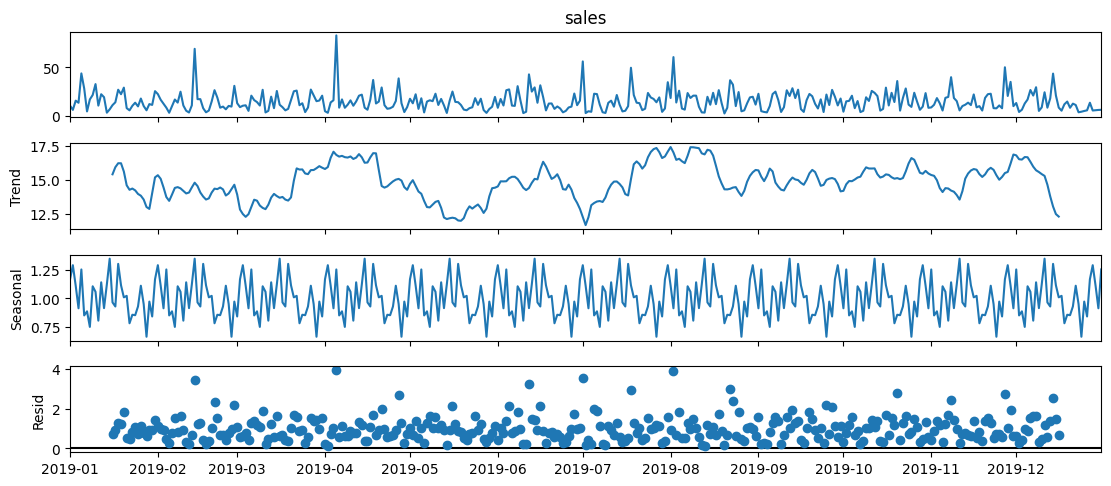

In [19]:
result = seasonal_decompose(train_df.groupby(by='date')['sales'].mean(), model='multiplicative', period=30)
fig = result.plot()
fig.set_size_inches(12, 5)


The plot includes four subplots:
1. Observed: The original time series data.
2. Trend: The long-term trend component of the time series.
3. Seasonal: The repeating short-term cycle in the time series.
4. Residual: The remaining noise after removing the trend and seasonal components. This decomposition helps in understanding the underlying patterns in the data, such as the overall trend, seasonal effects, and any irregularities.


The overall sales trend is increasing over time and there is a repeating cycle in the sales data every 30 days.

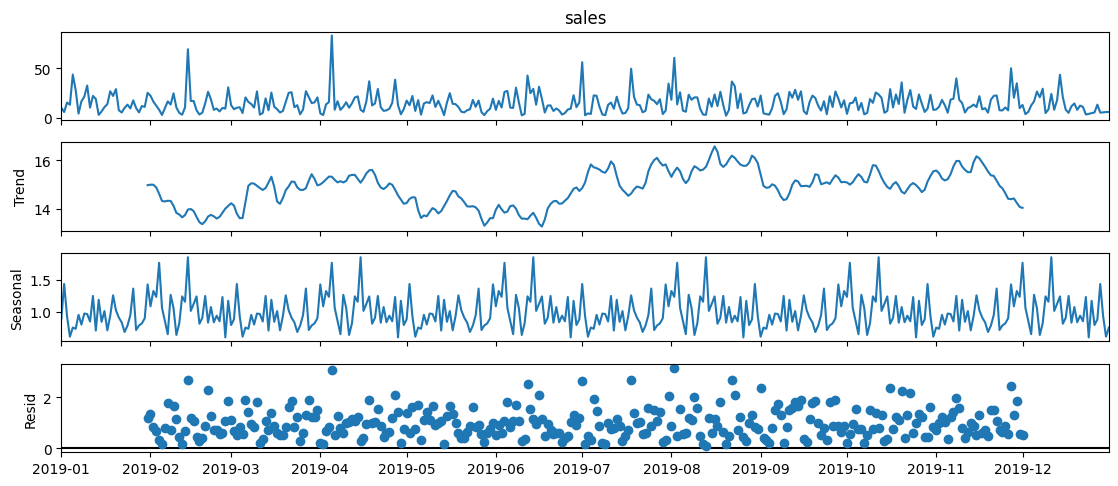

In [20]:
result = seasonal_decompose(train_df.groupby(by='date')['sales'].mean(), model='multiplicative', period=60)
fig = result.plot()
fig.set_size_inches(12, 5)

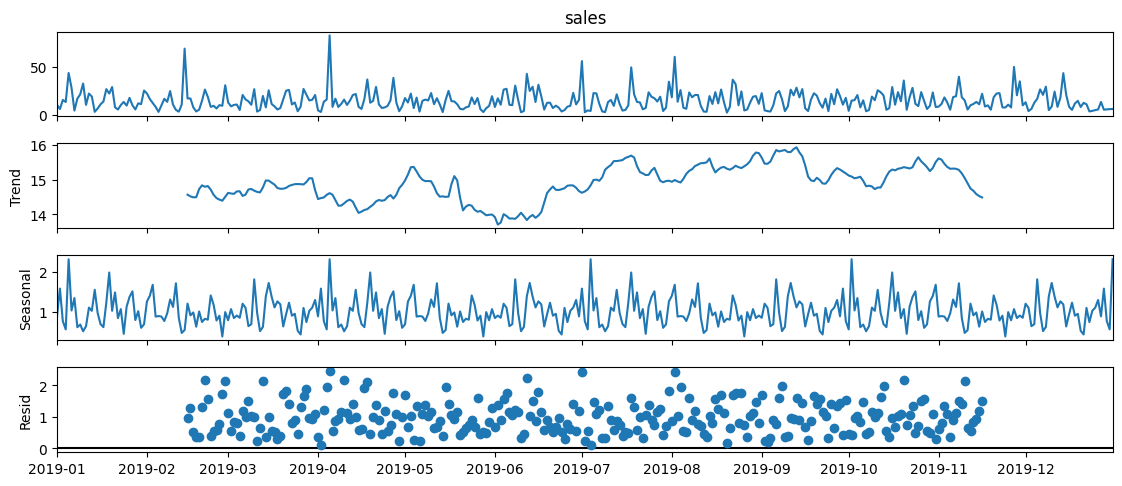

In [21]:
result = seasonal_decompose(train_df.groupby(by='date')['sales'].mean(), model='multiplicative', period=90)
fig = result.plot()
fig.set_size_inches(12, 5)

The data is rather clean and regular, and the patterns of trend and seasonality can be catched using: months and days of the week.

# Exploring Data Analysis

In [10]:
# convert product_id column to number by label encoding
encoder = LabelEncoder()
train_df['product_id'] = encoder.fit_transform(train_df['product_id'])
test_df['product_id'] = encoder.fit_transform(test_df['product_id'])

In [11]:
df = pd.concat([train_df, test_df], axis=0)

In [32]:
print("df dimensions:",df.shape) 
print("Test df dimensions:",test_df.shape)
print("Train df dimensions:",train_df.shape)

df dimensions: (27285, 3)
Test df dimensions: (11970, 3)
Train df dimensions: (15315, 3)


The code calculates the quantiles (percentiles) of the data in the DataFrame 'df' for the specified quantile levels [0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]. It transposes the resulting DataFrame to display the quantiles for each column as rows.

In [91]:
df.select_dtypes(include=['number','datetime']).quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

,0.00,0.05,0.25,0.50,0.75,0.95,0.99,1.00
date,2019-01-01 00:00:00,2019-02-04 00:00:00,2019-06-05 00:00:00,2019-11-07 00:00:00,2020-02-08 00:00:00,2020-03-20 00:00:00,2020-03-28 00:00:00,2020-03-30 00:00:00
sales,1.0,1.0,1.0,3.0,11.0,65.0,204.0,1197.0


In [33]:
df["date"].min()

Timestamp('2019-01-01 00:00:00')

In [34]:
df["date"].max()

Timestamp('2020-03-30 00:00:00')

The code calculates descriptive statistics for the 'sales' column in the DataFrame 'df', including mean, standard deviation, minimum, maximum, and percentiles at the specified quantile levels [0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99].






In [167]:
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    15315.000000
mean        15.664120
std         46.451661
min          1.000000
10%          1.000000
30%          2.000000
50%          3.000000
70%          8.000000
80%         16.000000
90%         35.000000
95%         65.000000
99%        204.000000
max       1197.000000
Name: sales, dtype: float64

In [33]:
df["product_id"].nunique()

133

The code groups the DataFrame 'df' by "product_id", and then aggregates the "sales" column, calculating the sum, mean, median, and standard deviation of sales for each product in the dataset.






In [18]:
df.groupby(["product_id"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
               sum       mean median        std
product_id                                     
0             44.0   1.833333    1.0   1.307725
1            256.0   5.224490    1.0  24.930123
2           1553.0   6.902222    2.0  14.069320
3             60.0   1.463415    1.0   0.636300
4            282.0   2.256000    1.0   3.883181
...            ...        ...    ...        ...
128          113.0   1.883333    1.0   2.091886
129          113.0   1.883333    1.0   2.091886
130          225.0   4.017857    3.0   3.283518
131          247.0   9.500000    2.0  20.258825
132         2434.0  24.585859   10.0  35.936171

[133 rows x 4 columns]

# Feature Engineering

The code extracts various date-related features from the "date" column of the DataFrame 'df', such as month, day of the month, day of the year, week of the year, day of the week, and year. It also creates new binary features indicating whether the date is a weekend, month start, or month end.






In [12]:
df['month'] = df.date.dt.month
df['day_of_month'] = df.date.dt.day
df['day_of_year'] = df.date.dt.dayofyear
df['week_of_year'] = df.date.dt.isocalendar().week
df['day_of_week'] = df.date.dt.dayofweek
df['year'] = df.date.dt.year
df["is_wknd"] = df.date.dt.weekday // 4
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)

In [97]:
df.head()

,date,product_id,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2019-01-25,65,2.0,1,25,25,4,4,2019,1,0,0
1,2019-09-23,115,3.0,9,23,266,39,0,2019,0,0,0
2,2019-02-22,11,26.0,2,22,53,8,4,2019,1,0,0
3,2019-09-23,22,1.0,9,23,266,39,0,2019,0,0,0
4,2019-07-10,60,20.0,7,10,191,28,2,2019,0,0,0


# Random Noise 

The code defines a function 'random_noise' that takes a DataFrame as input and returns an array of random noise generated from a normal distribution with a scale of 1.6 and the same length as the input DataFrame.






In [13]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# Lag/Shifted Features 

The code sorts the DataFrame 'df' in place based on multiple columns, first by 'product_id', and then 'date' in ascending order. The 'head()' function is then used to display the first few rows of the sorted DataFrame.






In [14]:
df.sort_values(by=['product_id', 'date'], axis=0, inplace=True)
df.head()

,date,product_id,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
499,2019-01-13,0,1.0,1,13,13,2,6,2019,1,0,0
2004,2019-02-21,0,4.0,2,21,52,8,3,2019,0,0,0
2083,2019-02-23,0,1.0,2,23,54,8,5,2019,1,0,0
3278,2019-03-21,0,3.0,3,21,80,12,3,2019,0,0,0
3945,2019-04-05,0,1.0,4,5,95,14,4,2019,1,0,0


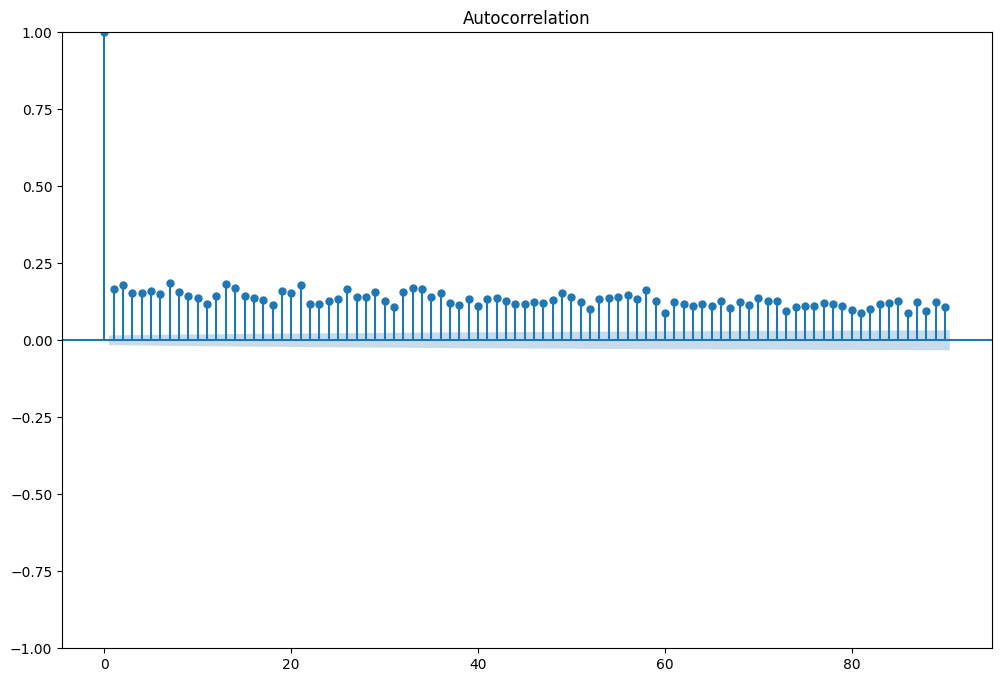

In [81]:
fig, ax = plt.subplots(1, figsize=(12, 8))
df2 = df.dropna(subset=['sales'])
plot_acf(df2['sales'], lags=90, ax=ax)
plt.show()

The code defines a function 'lag_features' that creates lagged features for the 'sales' column in the DataFrame 'df' by shifting the values by different time intervals specified in 'lags'. The function adds random noise to the shifted values and returns the updated DataFrame. The 'lag_features' function is then called with 'df' and a list of lag intervals to create the lagged features for the specified lags.






In [15]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["product_id"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

# df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])
df = lag_features(df,  [7, 14, 30, 60, 90])

# Rolling Mean Features

The code defines a function 'roll_mean_features' that calculates rolling mean features for the 'sales' column in the DataFrame 'df' using different rolling window sizes specified in 'windows'. The function applies the triangular rolling window with a minimum of 10 periods and adds random noise to the calculated rolling means. The updated DataFrame is then returned. The 'roll_mean_features' function is called with 'df' and a list of rolling window sizes to create the rolling mean features for the specified windows.






In [84]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["product_id"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=min(window,10), win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [7, 14, 30, 60,90])

# Exponentially Weighted Mean Features

The code defines a function 'ewm_features' that calculates exponentially weighted moving average (EWMA) features for the 'sales' column in the DataFrame 'df' using different smoothing factors (alphas) and lag intervals specified in 'alphas' and 'lags', respectively. The function applies the EWMA to the lagged 'sales' data within each group defined by 'product_id'. The updated DataFrame is then returned. The 'ewm_features' function is called with lists of alphas and lags to create the EWMA features for the specified combinations of smoothing factors and lag intervals






In [16]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["product_id"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
# lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]
lags =  [7, 14, 30, 60, 90]

df = ewm_features(df, alphas, lags)
df.head()

,date,product_id,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_7,sales_lag_14,sales_lag_30,sales_lag_60,sales_lag_90,sales_ewm_alpha_099_lag_7,sales_ewm_alpha_099_lag_14,sales_ewm_alpha_099_lag_30,sales_ewm_alpha_099_lag_60,sales_ewm_alpha_099_lag_90,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_14,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_095_lag_60,sales_ewm_alpha_095_lag_90,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_14,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_09_lag_60,sales_ewm_alpha_09_lag_90,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_14,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_08_lag_60,sales_ewm_alpha_08_lag_90,sales_ewm_alpha_07_lag_7,sales_ewm_alpha_07_lag_14,sales_ewm_alpha_07_lag_30,sales_ewm_alpha_07_lag_60,sales_ewm_alpha_07_lag_90,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_14,sales_ewm_alpha_05_lag_30,sales_ewm_alpha_05_lag_60,sales_ewm_alpha_05_lag_90
499,2019-01-13,0,1.0,1,13,13,2,6,2019,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,2019-02-21,0,4.0,2,21,52,8,3,2019,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2083,2019-02-23,0,1.0,2,23,54,8,5,2019,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3278,2019-03-21,0,3.0,3,21,80,12,3,2019,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3945,2019-04-05,0,1.0,4,5,95,14,4,2019,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The code performs one-hot encoding on the 'day_of_week' and 'month' columns of the DataFrame 'df', creating binary columns for each unique value in these columns, effectively converting categorical variables into numerical format.






In [17]:
df = pd.get_dummies(df, columns=['day_of_week', 'month'])

The code applies the natural logarithm transformation (logarithm with base e) to the 'sales' column in the DataFrame 'df', using the numpy function 'np.log1p', which handles zero values gracefully by adding 1 before taking the logarithm. This transformation is often used to stabilize the variance and improve the performance of certain models.






In [18]:
df['sales'] = np.log1p(df["sales"].values)

# Finding the best model

The code creates two new DataFrames, 'train' and 'val', by filtering rows from the original DataFrame 'df' based on the dates. 'train' contains data before September, 2019, and 'val' contains data between October 1, 2019, and December 1, 2019. The variable 'cols' is defined as a list of column names from 'train' DataFrame, excluding the columns 'date', 'product_id', 'sales', and 'year'.






In [19]:
train = df.loc[(df["date"] < "2019-09-01"), :]

val = df.loc[(df["date"] > "2019-09-01") & (df["date"] < "2019-12-31"), :]

cols = [col for col in train.columns if col not in ['date', "sales", "year"]]

The code creates four new variables: 'Y_train' and 'Y_val' are the target variables containing the 'sales' data for the training and validation sets, respectively. 'X_train' and 'X_val' are the feature matrices containing the selected columns (excluding 'date', 'id', 'sales', and 'year') for the training and validation sets, respectively. The final line displays the shapes of these arrays, indicating the number of rows and columns in each set.






In [20]:
Y_train = train['sales']

X_train = train[cols]

Y_val = val['sales']

X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((11062,), (11062, 61), (4175,), (4175, 61))

## Linear Regression model
We will start off with the simplest model and proceed to experiment with other models to see which performs the best

In [24]:
# Drop NaN values from X
x_train = X_train.dropna()
y_train = Y_train[X_train.index.isin(x_train.index)]
x_val = X_val.dropna()
y_val = Y_val[X_val.index.isin(x_val.index)]

# Train the model
model = LinearRegression()
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_val)

# Evaluate performance
rmse = root_mean_squared_error(y_val, y_pred)
print(f'Root Mean Squared Error: {rmse}')

# MAE for Linear Regression
mae = mean_absolute_error(y_val, y_pred)
print(f'Mean Absolute Error: {mae}')


Root Mean Squared Error: 1.2406237413014822
Mean Absolute Error: 0.8646878784128806


The next model to try will be random forest and we will see how it performs.

## Random Forest 

In [25]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_val)

# Evaluate performance
rmse = root_mean_squared_error(y_val, y_pred)
print(f'Root Mean Squared Error: {rmse}')
mae = mean_absolute_error(y_val, y_pred)
print(f'Mean Absolute Error: {mae}')

Root Mean Squared Error: 0.9704567335660632
Mean Absolute Error: 0.7585597113742578


As seen, the rmse for random forest is lower than linear regression model. Next, we will try LightGBM model and see if we can get better results.

## LightGBM Model

## Custom Cost Function

The code defines two functions: 'smape' calculates the Symmetric Mean Absolute Percentage Error (SMAPE) for two arrays of predictions and true target values, while 'lgbm_smape' computes SMAPE for LightGBM predictions by converting them back from log-scale using 'np.expm1' and comparing with the original labels.






In [56]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

The code defines a dictionary 'param_grid' containing various parameters for the LightGBM model, including the evaluation metric (Mean Absolute Error - 'mae'), number of leaves, learning rate, feature fraction, maximum depth, verbosity, number of boosting rounds, early stopping rounds, . These parameters will be used to configure the LightGBM model for training and evaluation. We will be using GridSearch to find the best set of parameters.






In [ ]:
param_grid = {
    'metric': ['mae'],  
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'feature_fraction': [0.7, 0.8, 0.9],
    'max_depth': [3, 5, 7]
}

model = lgb.LGBMRegressor(colsample_bytree=None)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', 
                           cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, Y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters from grid search: {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'metric': 'mae', 'num_leaves': 20}

After attempting this, the results are not as good so we will proceed to use bayes optimization as lightgbm also has their cross validation which can be used to find the best set of parameters and bayes optimization is also more efficient than grid search or random search because it uses a probabilistic model to predict the performance of different hyperparameter combinations and focuses on the most promising areas of the hyperparameter space.

In [50]:
from bayes_opt import BayesianOptimization

def bayes_parameter_opt_lgb(X, y, init_round=20, opt_round=30, n_folds=5, random_seed=6, n_estimators=10000,
                            learning_rate=0.05, output_process=False):
    # prepare data

    train_data = lgb.Dataset(data=X, label=y)
    # parameters

    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, 
                 lambda_l1, lambda_l2, min_split_gain, min_child_weight):

        params = {'objective':'regression','num_iterations':1000, 'learning_rate':0.05,
                  'early_stopping_round':100, 'metric':'rmse'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        
        cv_result = lgb.cv(params, train_data, nfold=3, seed=random_seed,
                           stratified=False, metrics=['rmse'])
        # print(cv_result)

        # return min(cv_result['rmse-mean'])
        return cv_result['valid rmse-mean'][-1]

    # setting range of the parameters
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.5, 1),
                                            'max_depth': (5, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 60)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return
    return lgbBO

opt_params = bayes_parameter_opt_lgb(X_train, Y_train, init_round=5, opt_round=10, n_folds=3,
                                     random_seed=6, n_estimators=10000, learning_rate=0.05)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[210]	cv_agg's valid rmse: 0.887178 + 0.0152378
| 1         | 0.8872    | 0.7744    | 0.6722    | 3.014     | 1.635     | 6.69      | 40.52     | 0.04432   | 42.73     |
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[295]	cv_agg's valid rmse: 0.888197 + 0.0127539
| 2         | 0.8882    | 0.9818    | 0.4068    | 3.959     | 1.587     | 7.266     | 55.91     | 0.008033  | 25.83     |
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[172]	cv_agg's valid rmse: 0.890002 + 0.0146477
| 3         | 0.89      | 0.5101    | 0.7661    | 3.891     | 2.61      | 8.9

In [51]:
params = opt_params.max['params']
params

{'bagging_fraction': 0.5,
 'feature_fraction': 0.1,
 'lambda_l1': 0.0,
 'lambda_l2': 3.0,
 'max_depth': 8.99,
 'min_child_weight': 50.110469118530524,
 'min_split_gain': 0.001,
 'num_leaves': 34.52532309414439}

After obtaining the best params, they will be used for training the model

The code sets up the LightGBM datasets for training and validation ('lgbtrain' and 'lgbval') with specified features and labels. It then trains the LightGBM model using 'lgb_params' with early stopping based on the validation set, and evaluates the model's performance using SMAPE on the validation set, which is then calculated on the predicted target values ('y_pred_val') and the true target values ('Y_val').






In [36]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

lgb_params= {
    'objective': 'regression',
    'metric': 'mae',
    'bagging_fraction': 0.5,
    'feature_fraction': 0.1,
    'num_boost_round': 10000,
    'lambda_l1': 0.0,
    'lambda_l2': 3.0,
    'max_depth': 9,
    'min_child_weight': 50.110469118530524,
    'min_split_gain': 0.001,
    'num_leaves': 35,
    'verbose' : -1}

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  feval=lgbm_smape,
                  callbacks=[lgb.early_stopping(stopping_rounds=500), lgb.log_evaluation(100)])


y_pred_val = model.predict(X_val, num_iteration=model.best_iteration) 

smape(np.expm1(y_pred_val), np.expm1(Y_val))

Training until validation scores don't improve for 500 rounds
[100]	training's l1: 0.572854	training's SMAPE: 64.6801	valid_1's l1: 0.680651	valid_1's SMAPE: 72.5047
[200]	training's l1: 0.507241	training's SMAPE: 58.7196	valid_1's l1: 0.672726	valid_1's SMAPE: 71.4971
[300]	training's l1: 0.467315	training's SMAPE: 54.9772	valid_1's l1: 0.676583	valid_1's SMAPE: 71.8813
[400]	training's l1: 0.432573	training's SMAPE: 51.5854	valid_1's l1: 0.679283	valid_1's SMAPE: 72.148
[500]	training's l1: 0.405673	training's SMAPE: 48.8969	valid_1's l1: 0.682671	valid_1's SMAPE: 72.5256
[600]	training's l1: 0.379876	training's SMAPE: 46.2489	valid_1's l1: 0.687308	valid_1's SMAPE: 73.0662
Early stopping, best iteration is:
[196]	training's l1: 0.509681	training's SMAPE: 58.9501	valid_1's l1: 0.672137	valid_1's SMAPE: 71.4397


71.43969760237457

**Best iteration is: [196]	training's l1: 0.509681	training's SMAPE: 58.9501	valid_1's l1: 0.672137	valid_1's SMAPE: 71.4397**

In [37]:
model.save_model('model.txt')

The code separates the original DataFrame 'df' into the training set and the test set based on the presence of NaN values in the 'sales' column. It creates 'X_train' and 'X_test' as the feature matrices and 'Y_train' as the target variable containing non-NaN sales data for training.






In [91]:
#Final Model
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [39]:
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

In [40]:
Y_train.shape, X_train.shape, X_test.shape, test_preds.shape

((15315,), (15315, 66), (11970, 66), (11970,))

# Results
The predictions and actual sales level will be plotted and shown together in an interactive plot to visualise it.

In [47]:
# convert the predictions back to normal values from log transformed
predictions = np.expm1(test_preds)

forecast = pd.DataFrame({"date":test["date"],
                        "product":test["product_id"],
                        "sales":predictions
                        })

In [43]:
#convert the product id to original values
forecast["product"] = encoder.inverse_transform(forecast["product"])

In [44]:
forecast.to_csv("forecast.csv", index=False)

In [42]:
#find the product that has the highest sales
forecast[forecast["sales"]==forecast["sales"].max()]


,date,product,sales
30,2020-01-01,75,87.234418


<Axes: xlabel='date'>

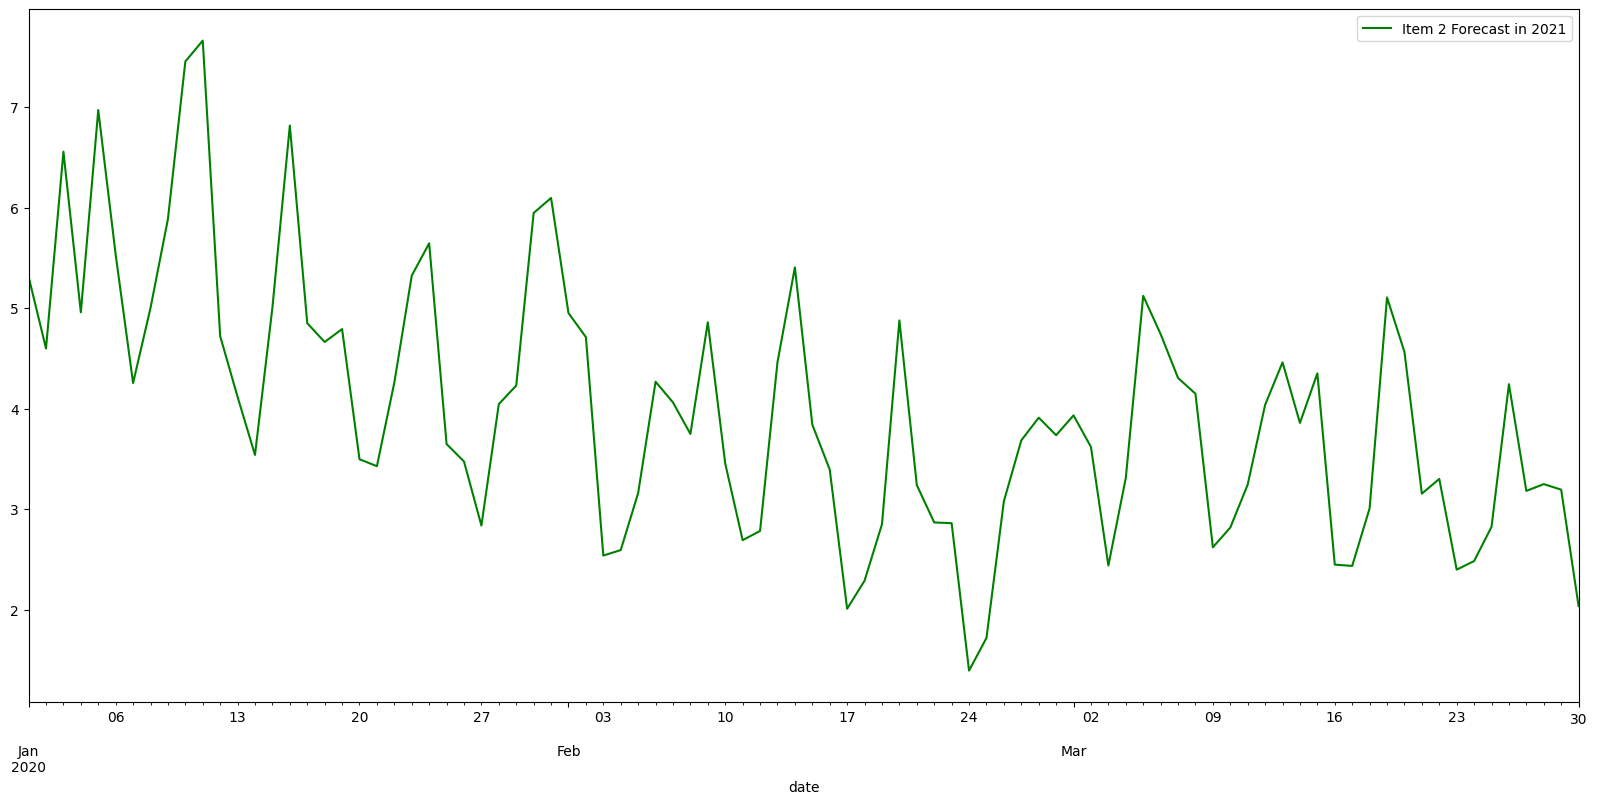

In [48]:
forecast[forecast['product'] == 2].set_index("date").sales.plot(color = "green", figsize = (20,9),legend=True, label = "Item 2 Forecast in 2021")


In [49]:
def forecast_demand(product_id):
    actual = df[(df['product_id']== product_id)]
    # change actual to normal values from log transformed
    actual['sales'] = np.expm1(actual['sales'].values)
    actual['type'] = 'actual'
    forecasted = forecast[(forecast['product'] == product_id)]
    forecasted['type'] = 'forecast'
    product_df = pd.concat([actual,forecasted], axis = 0)
    fig = px.line(product_df, x='date', y='sales', color='type',title=f'Item {encoder.classes_[product_id]} Demand Forecast in 2021')
    fig.show()
    

forecast_demand(75)

In [43]:
# find the product id before encoding
encoder.inverse_transform([75])[0]

'B08XMG618K'

In [50]:
def forecast_demand(product_id):
    actual = df[(df['product_id']== product_id)]
    # change actual to normal values from log transformed
    actual['sales'] = np.expm1(actual['sales'].values)
    actual['type'] = 'actual'
    forecasted = forecast[(forecast['product'] == product_id)]
    forecasted['type'] = 'forecast'
    product_df = pd.concat([actual,forecasted], axis = 0)
    fig = px.line(product_df, x='date', y='sales', color='type',title=f'Item {encoder.classes_[product_id]} Demand Forecast in 2021')
    fig.show()
    

forecast_demand(115)

# Inventory Optimization
Now that we have forecasted the demand for each product, we can use the forecasted demand to calculate the optimal inventory policy for the product.

Finding the optimal inventory policy will help us determine the Reorder Point, Safety Stock, and Economic Order Quantity(EOQ) for the product. These markers will help us ensure that we have the right amount of inventory on hand to meet customer demand while minimizing inventory costs.

## Re Order Point

The reorder point is the inventory level at which we should reorder more stock. ROP is calculated as the product of the average sales per day and the lead time (also referred to as Lead Time Demand) plus the Safety stock.

The `Lead Time` with regards to the reordering point is the time it takes for a product to be delivered by upstream supply chain manufacturers to the store's warehouse. It is the time between the placement of an order by the store and the receipt of the product.

We will query for the average upstream `Lead time` 

In [116]:
# query from shipping_history
def get_average_delivery_time():
    try:
        connection = engine.connect() # Connect to the database
        query = '''
        SELECT 
            AVG(estimated_delivery_date-date) 
        FROM
            shipping_status
        '''
        # Read data from database and return as integer
        days = pd.read_sql(query, con=connection).values[0][0]
        return math.ceil(days)
    except Exception as e:
        print("An error occurred:", e)
        connection.rollback()  # Rollback in case of error
    finally:
        connection.close()  # Close the connection

print(get_average_delivery_time())


5


In [92]:
# find the top selling product from train_df
top = train_df.groupby('product_id')['sales'].sum().sort_values(ascending=False).head(1).index[0]

# get the product id from train_df before encoding
product_id = encoder.inverse_transform([top])[0]

In [103]:
forecast = pd.read_csv("/Users/user/Passion8/demand_forecast/forecast.csv",header=0)

In [107]:
def find_lead_time_demand(product_id, average_lead_time):
    forecasted = forecast[(forecast['product'] == product_id)]
    average_forecasted_sales = forecasted['sales'].mean() # Extract the average forecasted sales per day from predictions
    lead_time_demand = average_forecasted_sales * average_lead_time
    return round(lead_time_demand,1)

lead_time_demand = find_lead_time_demand(product_id, get_average_delivery_time())
print(f"Lead Time Demand: {lead_time_demand}")


Lead Time Demand: 51.6


## Safety Stock
The safety stock is the extra stock that is kept on hand to mitigate the risk of stockouts due to uncertainties in demand and lead time.

Safety Stock = (Maximum Daily Sales × Maximum Lead Time) − Lead Time Demand



In [108]:
# query to get maximum lead time from shipping_history
def get_max_lead_time():
    try:
        connection = engine.connect() # Connect to the database
        query = '''
        WITH shipments AS (
            SELECT 
                shipping_id, 
                MAX(update_date)-MIN(update_date) AS lead_time
            FROM
                shipping_history
            GROUP BY
                shipping_id
            ORDER BY
                lead_time DESC
        )
        SELECT 
            lead_time
        FROM
            shipments
        LIMIT 1
        '''
        # Read data from database and return as integer
        days = pd.read_sql(query, con=connection).values[0][0]
        return days
    except Exception as e:
        print("An error occurred:", e)
        connection.rollback()  # Rollback in case of error
    finally:
        connection.close()  # Close the connection

print(get_max_lead_time())

22


In [111]:
# find maximum daily forecasted sales
def find_safety_stock(product_id, max_lead_time, avg_lead_time):
    forecasted = forecast[(forecast['product'] == product_id)]
    max_daily_forecasted_sales = forecasted['sales'].max()
    lead_time_demand = max_daily_forecasted_sales * avg_lead_time
    safety_stock = (max_daily_forecasted_sales * max_lead_time) - lead_time_demand
    return round(safety_stock,1)

safety_stock = find_safety_stock(product_id, get_max_lead_time(), get_average_delivery_time())
print(f"Safety Stock: {safety_stock}")

Safety Stock: 1024.1


The safety stock will need to be `1025` to mitigate the risk of stockouts due to uncertainties in demand and lead time.

## Calculate reorder point

In [113]:
reorder_point = lead_time_demand + safety_stock
print(f"The Optimal Reorder Point for the Top-selling Product is: {round(reorder_point,0)}")

The Optimal Reorder Point for the Top-selling Product is: 1076.0


As indicated by the result, the reorder point for the max product is `1076` units, which means that we should reorder more stock when the inventory level reaches `1076` units. This will help us ensure that we have enough stock on hand to meet customer demand while minimizing inventory costs.

## Economic Order Quantity (EOQ)
It is used to calculate the optimal order quantity for the top-selling product. The EOQ model helps us determine the optimal order quantity that minimizes the total inventory costs.

Unlike the Reorder Point which is concerned with determining the level of inventory at which a new order should be placed to avoid stockouts, EOQ takes into account the costs of ordering (e.g., setup costs) and the costs, of holding inventory (e.g., storage costs, opportunity costs).

For our analysis, we will assume that the ordering and holding cost is 10% and 30% of the product price respectively since I do not have data on that.

In [114]:
def create_df():
    try:
        connection = engine.connect() # Connect to the database
        query = '''
        SELECT 
            product_id, actual_price
        FROM
            online_sales 
        JOIN
            products
        USING
            (product_id)
        GROUP BY
            product_id, actual_price
        '''
        # Read data from the database into a DataFrame
        df = pd.read_sql(query, con=connection)
        return df
    except Exception as e:
        print("An error occurred:", e)
        connection.rollback()  # Rollback in case of error
    finally:
        connection.close()  # Close the connection

# Display the DataFrame
price_df = create_df()
price_df.head()

,product_id,actual_price
0,B08WRWPM22,5.99
1,B09NC2TY11,71.99
2,B00P0R95EA,7.68
3,B00KIE28X0,3.72
4,B09PNR6F8Q,4.79


In [115]:
# Calculate EOD
def calculate_EOD(product_id):
    product_price = price_df[price_df['product_id'] == product_id].actual_price.values[0]
    H = 0.10 * product_price
    S = 0.30 * product_price
    D = forecast[(forecast['product'] == product_id)]['sales'].mean()
    EOQ = round(np.sqrt((2 * D * S) / H))
    return D, H, S, EOQ
    
D, H, S, EOQ = calculate_EOD(product_id)
print(f"The Demand Rate is: {D}")
print(f"The Holding Cost is: {H}")
print(f"The Ordering Cost is: {S}")
print(f"The Economic Order Quantity is: {EOQ}")

The Demand Rate is: 10.703833372628322
The Holding Cost is: 1.854
The Ordering Cost is: 5.561999999999999
The Economic Order Quantity is: 8


Based on the EOQ model, the optimal order quantity for the top-selling product is `8` units. This means that we should order `8` units of the product at a time to minimize the total inventory costs. This will help us ensure that we have the right amount of inventory on hand to meet customer demand while minimizing inventory costs.